In [1]:
from tifffile import imread
import pandas as pd

# Bead stacks for model building
beads_stacks = imread('/media/Backup/smlm_z_data/20240603_Miguel_Zeiss_Stacks/beads/6um_10nm_stack_1/combined/stacks.ome.tif')
beads_locs = pd.read_hdf('/media/Backup/smlm_z_data/20240603_Miguel_Zeiss_Stacks/beads/6um_10nm_stack_1/combined/locs.hdf', key='locs')


In [4]:
# Time lapse for verification
import os
import numpy as np
import h5py
test_data_dir = '/media/Backup/smlm_z_data/20240606_bacteria_Miguel_zeiss/15min_timelapse_20nm_red_beads_every_1sec_1/'
test_case = '15min_timelapse_20nm_red_beads_every_1sec_1_MMStack_Default.ome.tif'
test_fpath = os.path.join(test_data_dir, test_case)

locs = pd.read_hdf(test_fpath.replace('.tif', '_locs.hdf5'), key='locs')
spots = test_fpath.replace('.tif', '_spots.hdf5')


from sklearn.cluster import DBSCAN
from data.visualise import show_psf_axial

locs['bead'] = DBSCAN().fit_predict(locs[['x', 'y']].to_numpy())
# sns.scatterplot(data=locs, x='x', y='y', hue='bead')
# plt.show()

idx = 16

spots_idx = np.argwhere(locs['bead']==16)[:, 0]
with h5py.File(spots) as f:
    spots_f = np.array(f['spots'])

spots_bead = spots_f[spots_idx]
print(spots_bead.shape)
show_psf_axial(spots_bead)



(900, 15, 15)


In [5]:
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import mean_squared_error
import h5py 

def reduce_img(stack):
    return stack.max(axis=(1,2))

PX_SIZE = _, 106, 106
def get_lat_fwhm(image, debug=False, mse_thres=0.001):
    
    def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
        x, y = xy
        xo = float(xo)
        yo = float(yo)
        a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
        b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
        c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
        g = offset + amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
        return g.ravel()

    # Load and preprocess the image (e.g., convert to grayscale)
    # For simplicity, let's generate a simple image for demonstration
    image_size = image.shape[1]
    x = np.linspace(0, image_size - 1, image_size)
    y = np.linspace(0, image_size - 1, image_size)
    x, y = np.meshgrid(x, y)
    
    image = image / image.max()

    # Fit the Gaussian to the image data
    p0 = [1, image_size / 2, image_size / 2, 2, 2, 0, 0]  # Initial guess for parameters
    bounds = [
        (0, np.inf),
        (image_size * (1/5), image_size),
        (image_size * (1/5), image_size),
        (0, image_size),
        (0, image_size),
        (-np.inf, np.inf),
        (0, np.inf),
    ]

    try:
        popt, pcov = curve_fit(gaussian_2d, (x, y), image.ravel(), p0=p0, bounds=list(zip(*bounds)))
    except RuntimeError as e:
        popt = p0
    render = gaussian_2d((x, y), *popt).reshape(image.shape)

    error = mean_squared_error(render, image)
    if error > mse_thres:
        fwhm_x, fwhm_y =  np.nan, np.nan
    else:
        amplitude, xo, yo, sigma_x, sigma_y, theta, offset = popt
        f = 2 * np.sqrt(2 * np.log(2))
        fwhm_x = sigma_x * f * PX_SIZE[1]
        fwhm_y = sigma_y * f * PX_SIZE[2]


    if debug:
        plt.figure(figsize=(2,2))
        print('FWHM x:', round(fwhm_x, 3), 'nm')
        print('FWHM y:', round(fwhm_y, 3), 'nm')
        print('MSE   :', '{:.2e}'.format(error))
        plt.imshow(image)
        plt.show()
        print('\n')
    return fwhm_x, fwhm_y

fwhms = [get_lat_fwhm(img) for img in spots_bead]

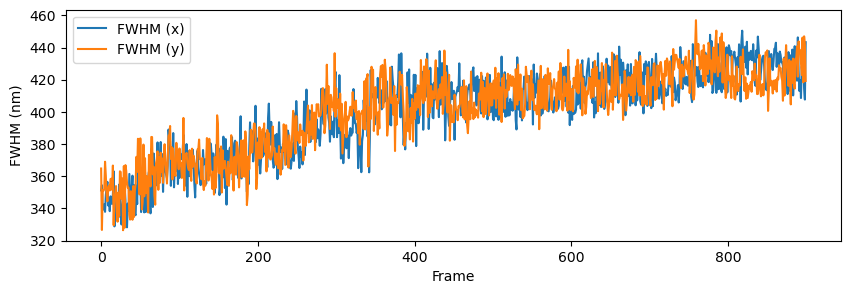

In [6]:
import matplotlib.pyplot as plt

fwhm_x = [x[0] for x in fwhms]
fwhm_y = [x[1] for x in fwhms]

plt.figure(figsize=(10, 3))
plt.plot(fwhm_x, label='FWHM (x)')
plt.plot(fwhm_y, label='FWHM (y)')
plt.legend()
plt.xlabel('Frame')
plt.ylabel('FWHM (nm)')
plt.show()

  1%|▋                                                                                | 3/350 [00:01<03:15,  1.78it/s]


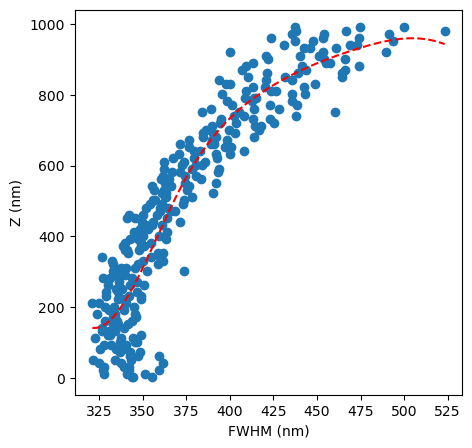

In [11]:
from tqdm import tqdm
from sklearn.linear_model import Ridge

def get_stack_fwhm(stack, l):
    z_vals = (np.arange(stack.shape[0]) * 10) - l['offset']
    idx = np.argwhere(((z_vals<1000) & (z_vals > 0)))[:, 0]
    sub_stack = stack[idx]
    peak = np.argmax(sub_stack.max(axis=(1,2)))
    z_vals = z_vals[idx]
    fwhms = np.mean(np.array([get_lat_fwhm(img, mse_thres=1, debug=False) for img in sub_stack]), axis=1)
    
    return z_vals, fwhms


z_fwhms = [get_stack_fwhm(s, l) for s, l in tqdm(zip(beads_stacks[:3], beads_locs.to_dict(orient='records')), total=beads_stacks.shape[0])]


plt.figure(figsize=(5,5))

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline


zs = np.concatenate([x[0] for x in z_fwhms]).reshape(-1, 1)
fwhms = np.concatenate([x[1] for x in z_fwhms]).reshape(-1, 1)

model = make_pipeline(SplineTransformer(5), Ridge(alpha=1e-1))

model.fit(fwhms, zs)

fwhms2 = np.linspace(min(fwhms), max(fwhms), 1000)
preds = model.predict(fwhms2)
plt.scatter(fwhms, zs)
plt.plot(fwhms2, preds, '--', c='red')
plt.xlabel('FWHM (nm)')
plt.ylabel('Z (nm)')
plt.show()